# Data Loader Pipeline Using Tensorflow Datasets & Tf.Data

## Design Principles
- Design the Data loader to make use of optimized Tf.Data Library
- Ensure the Data Input, Preprocessing & Augmentation operation is taken care of by the CPU to keep the GPU free for Model Training
- Use the Existing Tensorflow Dataset module to load and convert the ImageNet 2012 Train & Test Data
- Visualize the dataset once loaded, to ensure proper dataset formatting

## Optimizations
- Prefetch the next batch while the current batch is being processed
- Perform Data Augmentations as a Tensorflow Graph for Optimized Data Pipelining

## References
- Download the Dataset by Signing up with your Institution Email Addreess: [Download ImageNet Dataset](https://image-net.org/download-images)
- Tensorflow Datasets ImageNet2012 Dataset: [API Docs](https://www.tensorflow.org/datasets/catalog/imagenet2012)
- Efficient Data Pipelining using: [Tf.Data](https://www.tensorflow.org/guide/data)
- Tf.Data Training and Testing Split: [Slice & Split Docs](https://www.tensorflow.org/datasets/splits)
- Data Loader Template taken from my own Repository: [Zero Coding Tf Classifier](https://github.com/animikhaich/Zero-Code-TF-Classifier/blob/main/core/data_loader.py)

In [1]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

plt.rcParams["figure.figsize"] = 30, 30

# Dataset Format & Steps

Enough HDD/SSD space is required for the following:
- Downloading Raw Dataset - 156.8 GB
- Convert to TFRecord and Store - 155.9 GB
- Total Storage Required - 312.7 GB

An SSD is recommended and a Mechanical HDD should be avoided since it will slow down the data loader significantly. 

## Dataset Download

ImageNet Download Link: [Download ImageNet Dataset](https://image-net.org/download-images)

- Download Train Images (Required): `ILSVRC2012_img_train.tar` - Size 137.7 GB
- Download Val Images (Required): `ILSVRC2012_img_val.tar` - Size 6.3 GB
- Download Train Images (Optional): `ILSVRC2012_img_test.tar` - Size 12.7 GB

## Raw/Source Dataset Directory Structure
Download the dataset from the above link and put it in the folder like shown:
```
imagenet2012/
├── ILSVRC2012_img_test.tar
├── ILSVRC2012_img_train.tar
└── ILSVRC2012_img_val.tar
```

## Processed/Destination Dataset Directory Structure
Create another folder and create the folders `data`, `download` & `extracted` like shown:
```
imagenet/
├── data/
├── downloaded/
└── extracted/
```


In [2]:
class ImageNetDataLoader:
    def __init__(
        self,
        source_data_dir: str,
        dest_data_dir: str,
        split: str = "train",
        image_dims: tuple = (224, 224),
        num_classes=1000
    ) -> None:
        """
        __init__
        - Instance Variable Initialization
        - Download and Set Up Dataset (One Time Operation)
        - Use TFDS to Load and convert the ImageNet Dataset
        
        Args:
            source_data_dir (str): Path to Downloaded tar files
            dest_data_dir (str): Path to the location where the dataset will be unpacked
            spliit (str): Split to load as. Eg. train, test, train[:80%]. Defaults to "train"
            image_dims (tuple, optional): Image Dimensions (width & height). Defaults to (224, 224).
            num_classes (int): Number of Classes contained in this dataset. Defaults to 1000
        """
        
        # Constants
        self.NUM_CLASSES=num_classes
        self.BATCH_SIZE = None
        self.NUM_CHANNELS = 3
        self.LABELS = []
        self.LABELMAP = {}
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.WIDTH, self.HEIGHT = image_dims    
        
        # Download Config
        download_config = tfds.download.DownloadConfig(
            extract_dir=os.path.join(dest_data_dir, 'extracted'),
            manual_dir=source_data_dir
        )

        download_and_prepare_kwargs = {
            'download_dir': os.path.join(dest_data_dir, 'downloaded'),
            'download_config': download_config,
        }
        
        # TFDS Data Loader (This step also performs dataset conversion to TFRecord)
        self.dataset, self.info = tfds.load(
            'imagenet2012', 
            data_dir=os.path.join(dest_data_dir, 'data'),         
            split=split, 
            shuffle_files=True, 
            download=True, 
            as_supervised=True,
            with_info=True,
            download_and_prepare_kwargs=download_and_prepare_kwargs
        )
    
    
    def preprocess_image(self, image, label):
        """
        preprocess_image
        
        Process the image and label to perform the following operations:
        - Min Max Scale the Image (Divide by 255)
        - Convert the numerical values of the lables to One Hot Encoded Format
        - Resize the image to 224, 224
        
        Args:
            image (Image Tensor): Raw Image
            label (Tensor): Numeric Labels 1, 2, 3, ...
        Returns:
            tuple: Scaled Image, One-Hot Encoded Label
        """
        image = tf.cast(image, tf.uint8)
        image = tf.image.resize(image, [self.HEIGHT, self.WIDTH])
        image = image / tf.math.reduce_max(image)
        label = tf.one_hot(indices=label, depth=self.NUM_CLASSES)
        return image, label
    
    @tf.function
    def augment_batch(self, image, label) -> tuple:
        """
        augment_batch
        Image Augmentation for Training:
        - Random Contrast
        - Random Brightness
        - Random Hue (Color)
        - Random Saturation
        - Random Horizontal Flip
        - Random Reduction in Image Quality
        - Random Crop
        Args:
            image (Tensor Image): Raw Image
            label (Tensor): Numeric Labels 1, 2, 3, ...
        Returns:
            tuple: Augmented Image, Numeric Labels 1, 2, 3, ...
        """
        if tf.random.normal([1]) < 0:
            image = tf.image.random_contrast(image, 0.2, 0.9)
        if tf.random.normal([1]) < 0:
            image = tf.image.random_brightness(image, 0.2)
        if self.NUM_CHANNELS == 3 and tf.random.normal([1]) < 0:
            image = tf.image.random_hue(image, 0.3)
        if self.NUM_CHANNELS == 3 and tf.random.normal([1]) < 0:
            image = tf.image.random_saturation(image, 0, 15)
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_jpeg_quality(image, 10, 100)

        return image, label
    
    def get_dataset_size(self) -> int:
        """
        get_dataset_size
        Get the Dataset Size (Number of Images)
        Returns:
            int: Total Number of images in Dataset
        """
        return len(self.dataset)
    
    def get_num_steps(self) -> int:
        """
        get_num_steps
        Get the Number of Steps Required per Batch for Training
        Raises:
            AssertionError: Dataset Generator needs to be Initialized First
        Returns:
            int: Number of Steps Required for Training Per Batch
        """
        if self.BATCH_SIZE is None:
            raise AssertionError(
                f"Batch Size is not Initialized. Call this method only after calling: {self.dataset_generator}"
            )
        num_steps = self.get_dataset_size() // self.BATCH_SIZE + 1
        return num_steps
    
    def dataset_generator(self, batch_size=32, augment=False):
        """
        dataset_generator
        Create the Data Loader Pipeline and Return a Generator to Generate Datsets
        Args:
            batch_size (int, optional): Batch Size. Defaults to 32.
            augment (bool, optional): Enable/Disable Augmentation. Defaults to False.
        Returns:
            Tf.Data Generator: Dataset Generator
        """
        self.BATCH_SIZE = batch_size

        dataset = self.dataset.apply(tf.data.experimental.ignore_errors())

        dataset = dataset.shuffle(batch_size * 10)
        dataset = dataset.repeat()
               
        if augment:
            dataset = dataset.map(self.augment_batch, num_parallel_calls=self.AUTOTUNE)
        
        dataset = dataset.map(self.preprocess_image, num_parallel_calls=self.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=self.AUTOTUNE)

        return dataset
    
    def visualize_batch(self, augment=True) -> None:
        """
        visualize_batch
        Dataset Sample Visualization
        - Supports Augmentation
        - Automatically Adjusts for Grayscale Images
        Args:
            augment (bool, optional): Enable/Disable Augmentation. Defaults to True.
        """
        if self.NUM_CHANNELS == 1:
            cmap = "gray"
        else:
            cmap = "viridis"

        dataset = self.dataset_generator(batch_size=36, augment=augment)
        image_batch, label_batch = next(iter(dataset))
        image_batch, label_batch = (
            image_batch.numpy(),
            label_batch.numpy(),
        )

        for n in range(len(image_batch)):
            ax = plt.subplot(6, 6, n + 1)
            plt.imshow(image_batch[n], cmap=cmap)
            plt.title(np.argmax(label_batch[n]))
            plt.axis("off")
        plt.show()
        
data_loader = ImageNetDataLoader(
        source_data_dir = "/mnt/data/pycodes/Dataset/imagenet2012",
        dest_data_dir = "/home/ani/Documents/datasets/imagenet",
        split = "train",
        image_dims = (224, 224),
)

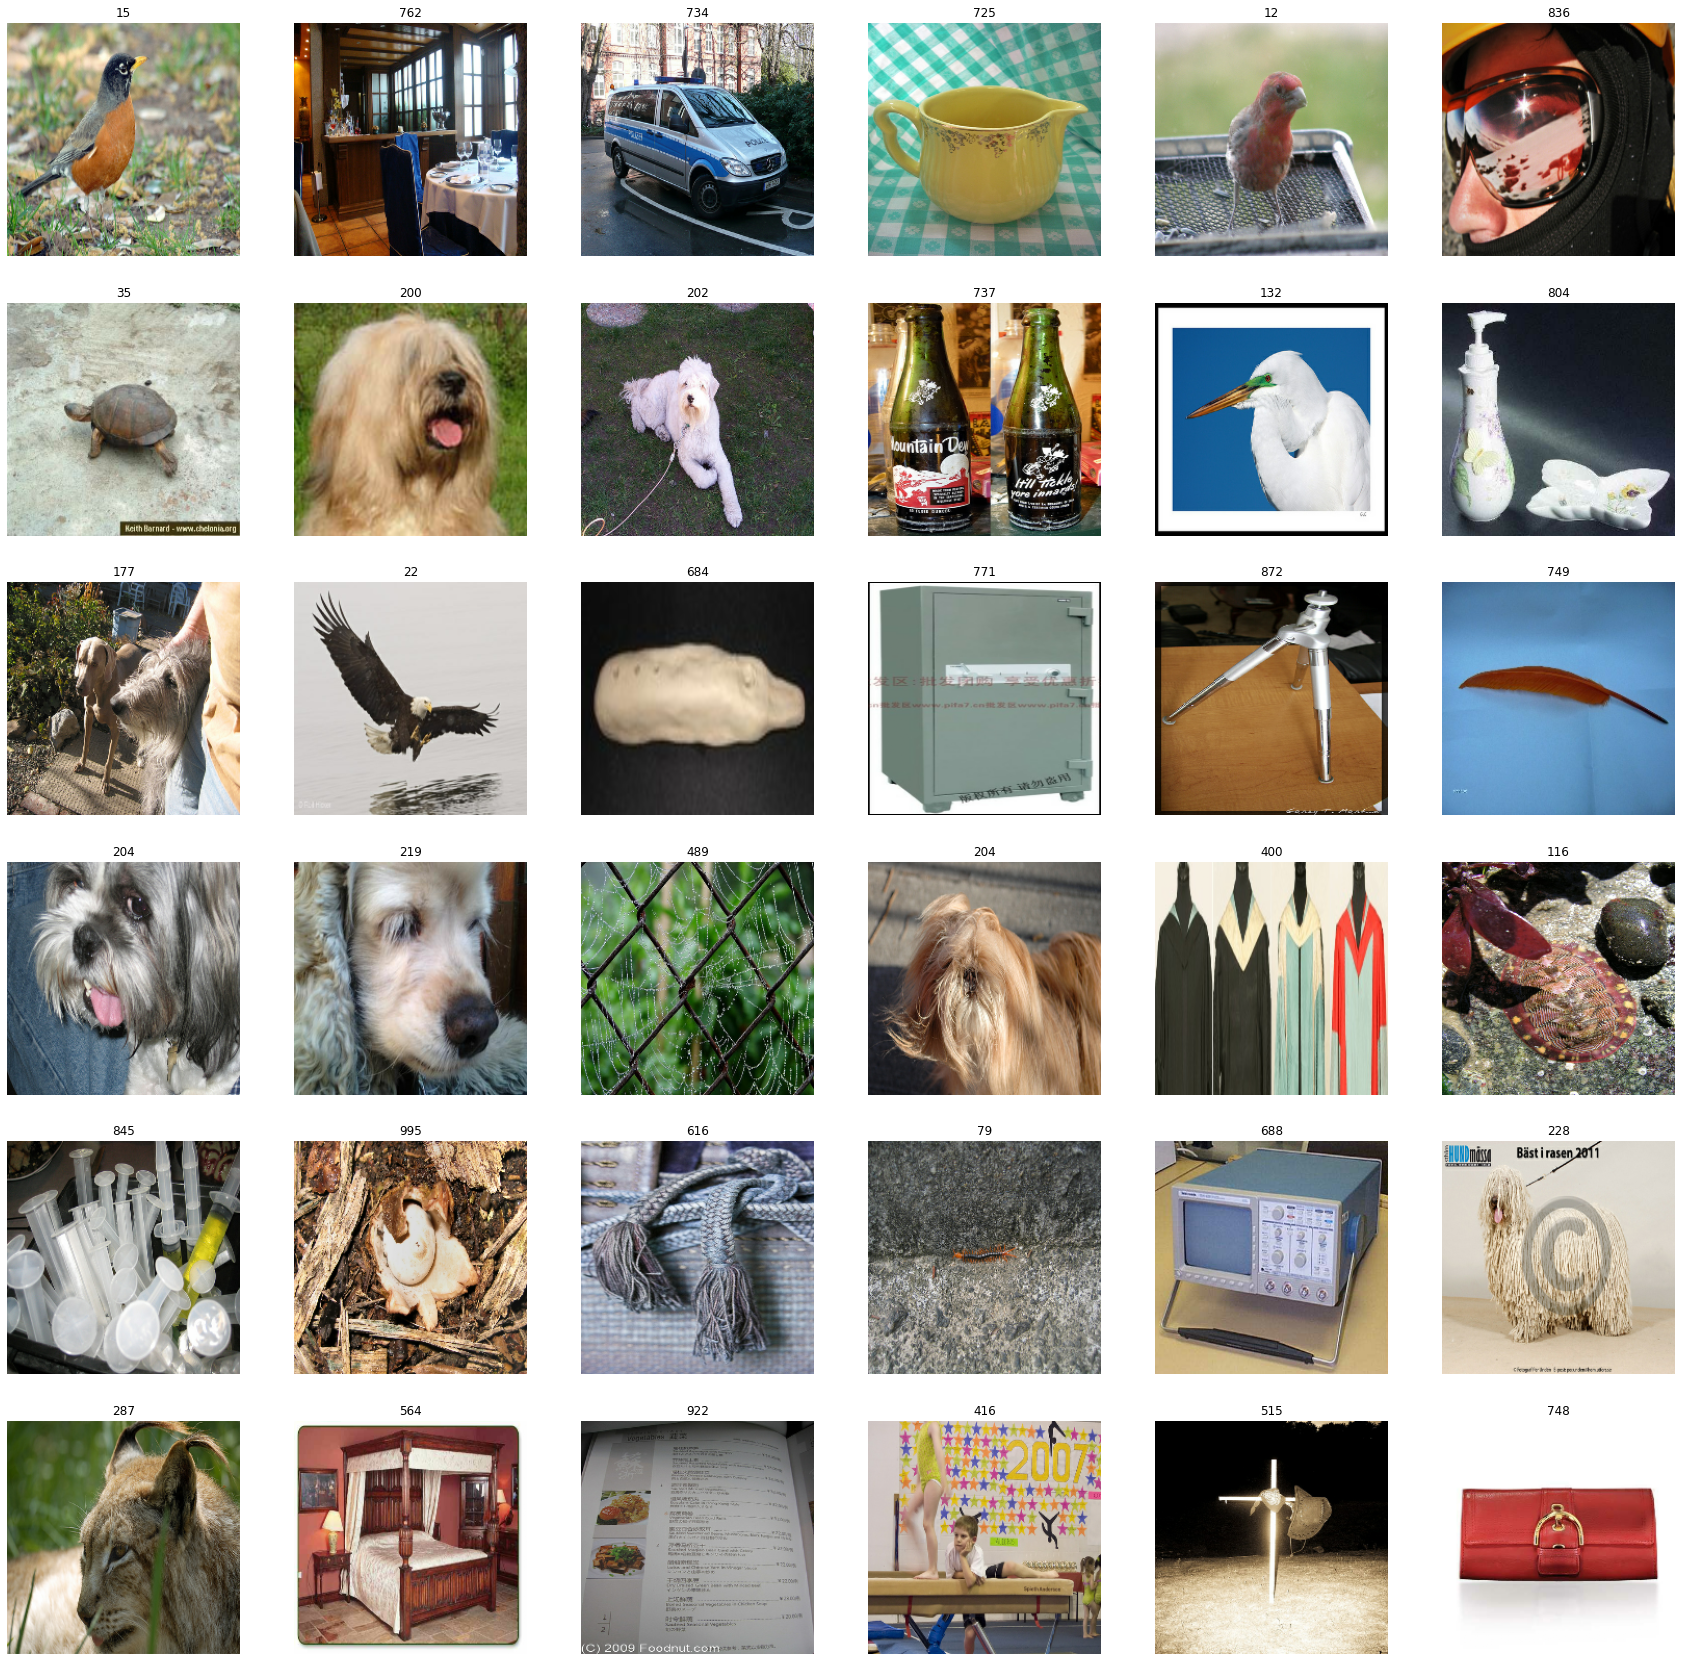

In [3]:
data_loader.visualize_batch(augment=False)

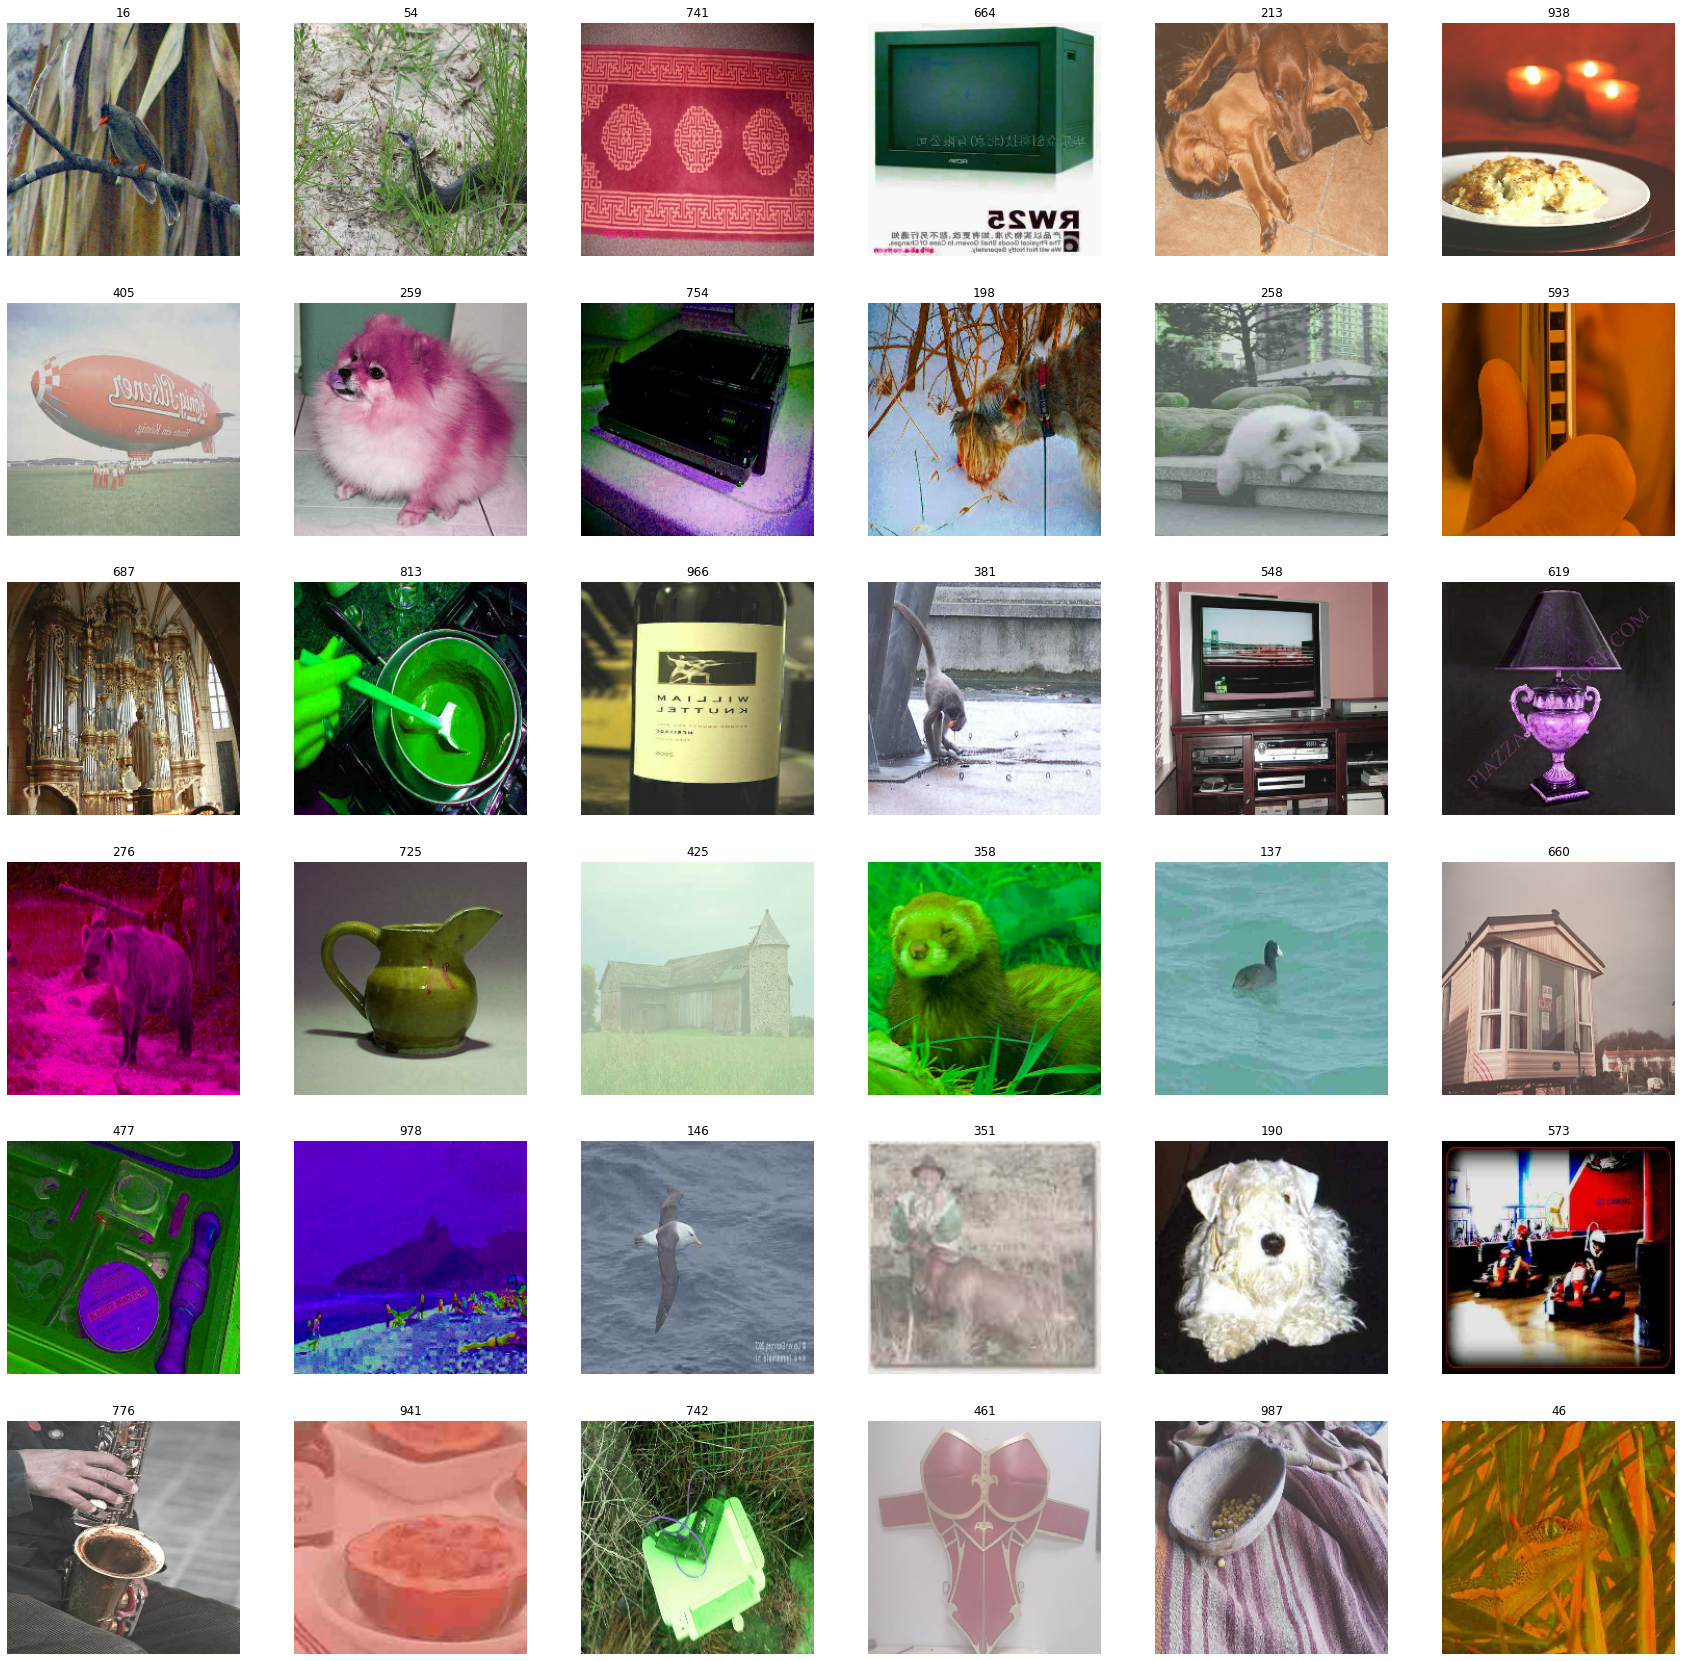

In [4]:
data_loader.visualize_batch(augment=True)

In [5]:
# Init Data Loaders
train_data_loader = ImageNetDataLoader(
        source_data_dir = "/mnt/data/pycodes/Dataset/imagenet2012",
        dest_data_dir = "/home/ani/Documents/datasets/imagenet",
        split = "train",
        image_dims = (224, 224),
)

val_data_loader = ImageNetDataLoader(
        source_data_dir = "/mnt/data/pycodes/Dataset/imagenet2012",
        dest_data_dir = "/home/ani/Documents/datasets/imagenet",
        split = "validation",
        image_dims = (224, 224),
)

test_data_loader = ImageNetDataLoader(
        source_data_dir = "/mnt/data/pycodes/Dataset/imagenet2012",
        dest_data_dir = "/home/ani/Documents/datasets/imagenet",
        split = "test",
        image_dims = (224, 224),
)

print("Train Dataset Size:", train_data_loader.get_dataset_size())
print("Validation Dataset Size:", val_data_loader.get_dataset_size())
print("Test Dataset Size:", train_data_loader.get_dataset_size())

Train Dataset Size: 1281167
Validation Dataset Size: 50000
Test Dataset Size: 1281167
